# Функция для автоматизации добавления метрик, расчету метрик и визуализации

Задача

1. Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализовать функцию, которая будет строить графики по получаемым метрикам.


В качестве аргумента функции задаем ссылку на источник с дополнительными данными, при условии, что все ссылки на исходные данные неизменны.

In [40]:
def add_info(add_linc):
    # Импортируем нужные библиотеки
    import pandas as pd
    import requests
    import urllib
    import json
    import seaborn as sns
    from matplotlib import pyplot as plt
    %matplotlib inline
    import numpy as np
    from urllib.parse import urlencode
    # Подгружаем наши данные
    groups = pd.read_csv(requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/UhyYx41rTt3clQ'))).json()['href'], sep=';', error_bad_lines=False, comment='#' , encoding='cp1251')
    checks = pd.read_csv(requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'))).json()['href'], sep=';', error_bad_lines=False, comment='#' , encoding='cp1251')
    active_studs = pd.read_csv(requests.get(base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))).json()['href'], sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')
    group_add = pd.read_csv(requests.get(base_url + urlencode(dict(public_key=add_linc))).json()['href'], sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')
    # Переименовываем столбцы в данных с дополнительной информацией, чтоб обьединить
    group_add.columns = groups.columns
    # Обьединяем данные старые и новые
    groups_all = pd.concat([groups, group_add], sort = False, axis = 0)
    # Обьединяем таблицу с группами и активными студентами, отбрасываем неактивных пользователей и пользователей,
    # не являющихся участниками эксперимента. 
    test_students = active_studs.merge(groups_all, left_on='student_id' , right_on='id', how = 'left').dropna()
    test_students = test_students[['student_id', 'grp']]
    # Объединяем таблицу с активными студентами, участвующими в тесте с информацией по чекам.
    AB_data = test_students.merge(checks, on='student_id', how = 'left')
    # Создаем категориальный столбец показывающий была ли совершена покупка у этого студента
    AB_data['is_rev'] = AB_data.rev.notna().astype(int)
    # Расчитываем конверсию в покупку
    AB_conv = AB_data.groupby('grp', as_index = False).agg({'student_id': 'count', 'rev': 'count'})
    AB_conv['CR'] = 100*(AB_conv['rev']/AB_conv['student_id']).round(4)
    #Визуализируем конверсию в покупку по группам
    #sns.barplot(data = AB_conv, x = 'grp', y = 'CR', palette='hls')
    print(f"В контрольной группе СR =  {AB_conv.CR[0]}%")
    print(f"В целевой группе СR =  {AB_conv.CR[1]}%")
    #Оставляем только данные с совершенными покупками
    AB_avg_check = AB_data.dropna()
    AB_avg = AB_avg_check.groupby('grp', as_index = False).agg({'rev': 'sum', 'is_rev':'sum'})
    AB_avg['avg_check'] = (AB_avg['rev']/AB_avg['is_rev']).round(2)
    print(f"В контрольной группе Средний чек =  {AB_avg.avg_check[0]} руб.")
    print(f"В целевой группе Средний чек =  {AB_avg.avg_check[1]} руб.")
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    conv = sns.barplot(data = AB_conv, x = 'grp', y = 'CR', palette='hls')
    conv.set_title("CR")
    plt.subplot(1, 2, 2)
    avg = sns.boxplot(x = 'grp', y = 'rev', data = AB_avg_check, palette='hls' )
    avg.set_title("Средний чек")

В контрольной группе СR =  5.07%
В целевой группе СR =  4.62%
В контрольной группе Средний чек =  933.59 руб.
В целевой группе Средний чек =  1257.88 руб.


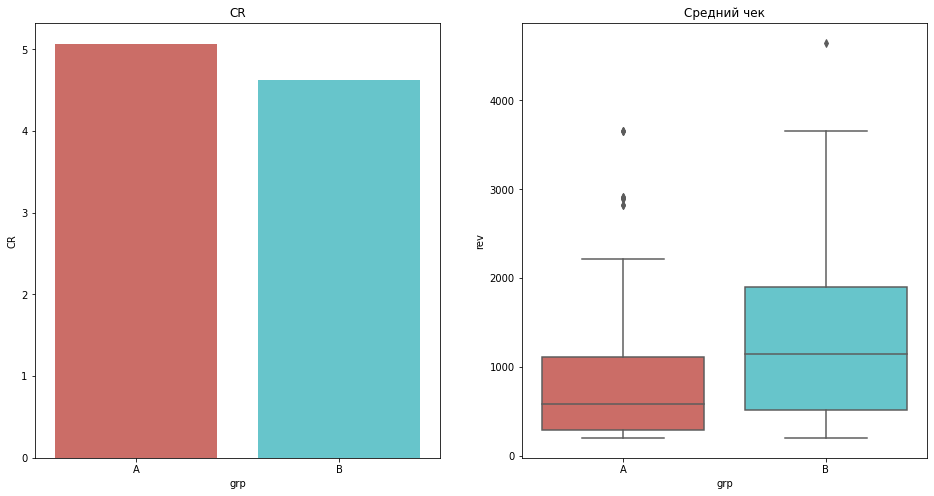

In [41]:
add_info('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')